# Drone mosaic correction and evaluation

This notebook uses `homonim` to correct a drone mosaic image to surface reflectance using a Sentinel-2 SR reference. It demonstrates the use of [geedim](https://github.com/leftfield-geospatial/geedim) for obtaining reference images.  Results are evaluated by comparison with a Landsat-8 reference.

The drone mosaic is supplied by [Open Aerial Map](https://openaerialmap.org/) under the [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.  It is a 5 cm resolution RGB ortho-image captured on 8 Feb 2022, covering small diverse area in Pereira, Colombia.  

## Setup

`geedim`, `gdal` and `matplotlib` are required to run the notebook.  You can uncomment the cell below to install them, if they aren't installed already.

In [1]:
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge geedim gdal matplotlib
# else:
#     # install into the python environment the notebook is being run from
#     !{sys.executable} -m pip install geedim gdal matplotlib

In [2]:
# imports used by more than one cell
import logging
import warnings
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm

import geedim as gd
from homonim import RasterCompare
from homonim.errors import HomonimWarning

# keep notebook free of homonim logs / warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter('ignore', category=HomonimWarning)

## Download drone image

In this step, we create an *images* sub-folder, then download the [drone ortho-image](https://oin-hotosm.s3.amazonaws.com/6202ec307b3a500007430480/0/6202ec307b3a500007430481.tif) into it.  

In [3]:
from urllib import request

# create images dir and source image path
src_url = (
    'https://oin-hotosm.s3.amazonaws.com/6202ec307b3a500007430480/0/'
    '6202ec307b3a500007430481.tif'
)
images_path = Path('images')
images_path.mkdir(exist_ok=True)

src_path = images_path.joinpath('ES_WMM3_2022_02_08_Pereira_RGB.tif')

In [4]:
# download
response = request.urlopen(src_url)
with tqdm(
    total=response.length, desc='Download', unit='B', unit_scale=True, 
    dynamic_ncols=True
) as pbar, open(src_path, 'wb')  as fout:
    for chunk in response:
        fout.write(chunk)
        pbar.update(len(chunk))

Download:   0%|                                                                            | 0.00/21.0M [00:00…

## Search for reference image

Now we search for a Sentinel-2 SR reference image using [geedim](https://github.com/leftfield-geospatial/geedim).  Sentinel-2 is chosen for its high spatial resolution (10 m).


In [5]:
gd.Initialize()
# create a search region that covers the source image
region = gd.utils.get_bounds(src_path)

# search the Sentinel-2 SR collection for >50% cloudless images
s2_coll = gd.MaskedCollection.from_name('COPERNICUS/S2_SR')
s2_coll = s2_coll.search(
    '2022-01-01', '2022-03-01', region, cloudless_portion=50, 
)
print('Image property descriptions:\n\n' + s2_coll.schema_table)
print('\nSearch Results:\n\n' + s2_coll.properties_table)

# equivalent geedim command line:
# !geedim search -c s2-sr -s 2022-01-01 -e 2022-03-01 -r {src_mosaic_path} -cp 50

Image property descriptions:

ABBREV     NAME                             DESCRIPTION
---------  -------------------------------  ----------------------------------------------
ID         system:id                        Earth Engine image id
DATE       system:time_start                Image capture date/time (UTC)
FILL       FILL_PORTION                     Portion of region pixels that are valid (%)
CLOUDLESS  CLOUDLESS_PORTION                Portion of filled pixels that are cloud/shadow
                                            free (%)
RADQ       RADIOMETRIC_QUALITY              Radiometric quality check
GEOMQ      GEOMETRIC_QUALITY                Geometric quality check
SAA        MEAN_SOLAR_AZIMUTH_ANGLE         Solar azimuth angle (deg)
SZA        MEAN_SOLAR_ZENITH_ANGLE          Solar zenith angle (deg)
VAA        MEAN_INCIDENCE_AZIMUTH_ANGLE_B1  View (B1) azimuth angle (deg)
VZA        MEAN_INCIDENCE_ZENITH_ANGLE_B1   View (B1) zenith angle (deg)

Search Results:

ID       

## Download reference image

Let's download *COPERNICUS/S2_SR/20220202T152639_20220202T152919_T18NVL* which is 100% cloudless and fairly close to the source capture date.

In [6]:
ref_path = Path('images/s2_sr_reference.tif')
gd_image = gd.MaskedImage.from_id(
    'COPERNICUS/S2_SR/20220202T152639_20220202T152919_T18NVL', mask=True
)
gd_image.download(ref_path, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim download -i COPERNICUS/S2_SR/20220202T152639_20220202T152919_T18NVL --mask -r {src_path}

s2_sr_reference.tif: |                                                 | 0.00/495k (raw) [  0.0%] in 00:00 (et…

## Surface reflectance correction

This is the main step, where we correct the drone image by fusion with the Sentinel-2 reference.  

The scale of variation that correction can adjust for is roughly the size of the kernel.  With a large disparity between the source (5 cm) and reference spatial (10 m) resolutions, it is best to keep the kernel size small.  For this example, we use the *gain-blk-offset* [model](../background.rst#model) and a [kernel shape](../background.rst#kernel-shape) of 3 x 3 pixels.  Of the tested settings, these produced the best accuracy.  

In [7]:
from homonim import RasterFuse, Model
corr_path = images_path.joinpath(src_path.stem + '_FUSE.tif')

In [8]:
with RasterFuse(src_path, ref_path) as raster_fuse:
    print(f'{corr_path.name}:')
    # incease max_block_mem below so that there is one block (and offset) 
    # per band
    raster_fuse.process(
        corr_path, Model.gain_blk_offset, (3, 3), 
        block_config=dict(max_block_mem=1024), 
        out_profile=dict(dtype='uint16', nodata=0), 
        overwrite=True
    )

    # equivalent homonim command line:
    # !homonim fuse -m gain-blk-offset -k 3 3 -o {src_path} {ref_path}

ES_WMM3_2022_02_08_Pereira_RGB_FUSE.tif:


  0%|                                                                                             |0/3 blocks …

## Visualisation

Next, we display matching extents of the source, reference and corrected images, in the reference CRS.

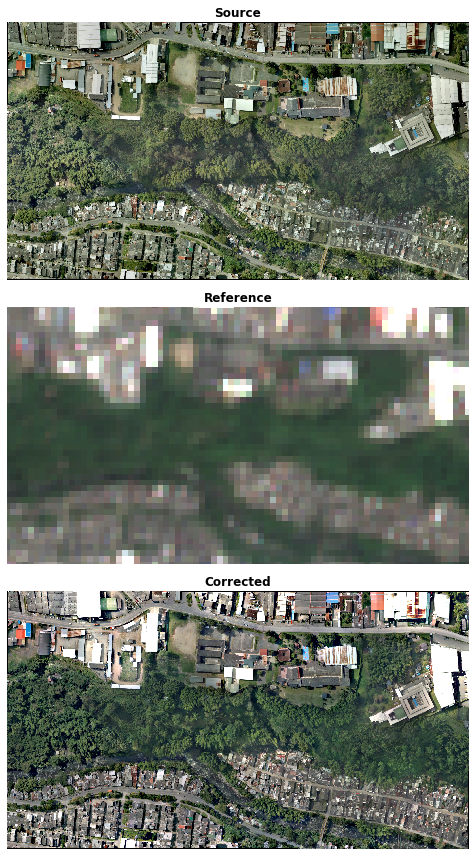

In [9]:
from rasterio.plot import show
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

fig, axes = pyplot.subplots(
    3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 12), 
    dpi=72,
)

# get the reference CRS to reproject source & corrected into 
with rio.open(ref_path, 'r') as ds:
    dst_crs = ds.crs

# loop over source, reference and corrected images, and their corresponding 
# settings
for im_file, ds_fact, sc_off, indexes, ax, label in zip(
    [src_path, ref_path, corr_path],
    [4, 1, 4],                           # downsampling factors
    [[255, 0], [3500, .2], [3500, .2]],  # colour scale & offset
    [None, [4, 3, 2], None],             # RGB band indices
    axes,
    ['Source', 'Reference', 'Corrected'], 
):
    # reproject into reference CRS
    with rio.open(im_file, 'r') as _ds, WarpedVRT(
        _ds, crs=dst_crs, resampling=Resampling.bilinear, 
    ) as ds:
        # read and downsample image
        ds_shape = tuple(np.round(np.array(ds.shape) / ds_fact).astype('int'))
        transform = ds.transform * rio.Affine.scale(ds_fact)
        array = ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

        # scale and offset pixel values
        array = np.clip((array / sc_off[0]) - sc_off[1], 0, 1)

    # display image
    ax = show(array, transform=transform, interpolation='nearest', ax=ax)
    ax.set_title(label, fontweight='bold')
    ax.axis('off')

# fig.savefig('../case_studies/_drone_mosaic-src_ref_corr.jpg', dpi=92)

The corrected and reference image colours correspond visually.  The next section quantifies the surface reflectance differences between source and corrected images.

## Evaluation

Here we compare the source and corrected images with a surface reflectance reference to get an idea of accuracy.  To avoid biasing accuracy estimates in the case of overfitting, we compare with an "independent" Landsat-8 reference i.e. a reference not used for correction. 

### Download comparison reference

We use `geedim` again to search for and download a Landsat-8 reference.


In [10]:
# search the Landsat-8 collection for >50% cloudless images
l8_coll = gd.MaskedCollection.from_name('LANDSAT/LC08/C02/T1_L2')
l8_coll = l8_coll.search(
    '2022-01-01', '2022-03-01', region, cloudless_portion=50, 
)
print('Image property descriptions:\n\n' + l8_coll.schema_table)
print('\nSearch Results:\n\n' + l8_coll.properties_table)

# equivalent geedim command line:
# !geedim search -c l8-c2-l2 -s 2022-01-01 -e 2022-03-01 -r {src_path} -cp 50

# download LANDSAT/LC08/C02/T1_L2/LC08_009057_20220215 
cmp_ref_path = Path('images/l8_reference.tif')
gd_image = gd.MaskedImage.from_id(
    'LANDSAT/LC08/C02/T1_L2/LC08_009057_20220215', mask=True
)
gd_image.download(cmp_ref_path, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim download -i LANDSAT/LC08/C02/T1_L2/LC08_009057_20220215 --mask -r {src_path}


Image property descriptions:

ABBREV     NAME                  DESCRIPTION
---------  --------------------  ----------------------------------------------
ID         system:id             Earth Engine image id
DATE       system:time_start     Image capture date/time (UTC)
FILL       FILL_PORTION          Portion of region pixels that are valid (%)
CLOUDLESS  CLOUDLESS_PORTION     Portion of filled pixels that are cloud/shadow
                                 free (%)
GRMSE      GEOMETRIC_RMSE_MODEL  Orthorectification RMSE (m)
SAA        SUN_AZIMUTH           Solar azimuth angle (deg)
SEA        SUN_ELEVATION         Solar elevation angle (deg)

Search Results:

ID                                          DATE              FILL CLOUDLESS GRMSE    SAA   SEA
------------------------------------------- ---------------- ----- --------- ----- ------ -----
LANDSAT/LC08/C02/T1_L2/LC08_009057_20220215 2022-02-15 15:18 99.85       100  7.94 120.07 55.94


l8_reference.tif: |                                                   | 0.00/47.3k (raw) [  0.0%] in 00:00 (et…

### Comparison

In this section we compare the source, and corrected similarity with the Landsat-8 reference.  

To start, we produce comparison tables using the `RasterCompare` class.  

In [11]:
print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_path, corr_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(
        im_path, cmp_ref_path,
    ) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        print(f'{im_label}:')
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV DESCRIPTION
------ -----------------------------------------
r²     Pearson's correlation coefficient squared
RMSE   Root Mean Square Error
rRMSE  Relative RMSE (RMSE/mean(ref))
N      Number of pixels
Source:


  0%|                                                                                             |0/6 blocks …

Source comparison:

 Band    r²      RMSE rRMSE   N
----- ----- --------- ----- ---
SR_B4 0.460 10694.173 1.013 405
SR_B3 0.381 10729.304 1.007 405
SR_B2 0.456  9474.613 1.010 405
 Mean 0.433 10299.363 1.010 405
Corrected:


  0%|                                                                                             |0/6 blocks …

Corrected comparison:

 Band    r²     RMSE rRMSE   N
----- ----- -------- ----- ---
SR_B4 0.906 8594.143 0.814 405
SR_B3 0.904 8572.302 0.804 405
SR_B2 0.863 7432.778 0.793 405
 Mean 0.891 8199.741 0.804 405


Now we create scatter plots for each of the spectral bands.

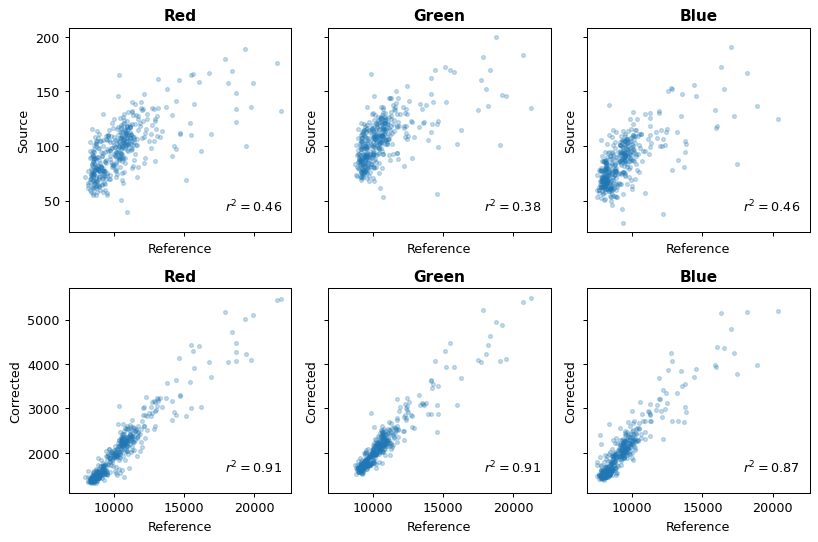

In [12]:
fig, axes = pyplot.subplots(
    2, 3, sharex='all', sharey='row', tight_layout=True, figsize=(9, 6), dpi=92
)

# loop over the source and corrected image files and corresponding axes etc
for im_i, im_path, im_label in zip(
    range(2),
    [src_path, corr_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(im_path, cmp_ref_path) as compare:
        # produce per-band scatter plots of source/corrected - reference 
        # surface reflectance 
        # (note that in RasterCompare.block_pairs a 'block' takes the size of a 
        # band by default)
        for band_i, block_pair, band_label in zip(
            range(3),
            compare.block_pairs(),
            ['Red', 'Green', 'Blue']
        ):
            # read source/corrected - reference band pair, and reproject the 
            # source/corrected band to the reference CRS and pixel grid
            src_ra, ref_ra = compare.read(block_pair)
            src_ra = src_ra.reproject(
                **ref_ra.proj_profile, resampling='average'
            )

            # vectors of valid pixels in the source/corrected and reference bands
            mask = src_ra.mask & ref_ra.mask  # mask of valid pixels
            src_v, ref_v = src_ra.array[mask], ref_ra.array[mask]
            r2 = np.corrcoef(src_v, ref_v)[0, 1] ** 2 

            # create scatter plot
            ax = axes[im_i, band_i]
            ax.plot(ref_v, src_v, '.', alpha=0.25)
            ax.set_xlabel('Reference')
            ax.set_ylabel(im_label)
            ax.set_title(band_label, fontweight='bold')
            ax.text(.7, .1, f'$r^2={r2:.2f}$', transform=ax.transAxes)

# fig.savefig(
#     '../case_studies/drone_mosaic-eval.png', facecolor='white', 
#     transparent=False, dpi=92, 
# )

The tables and scatter plots show an improvement in correlation with the Landsat-8 reference after correction.  